In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory
biomd_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioModels'
bigg_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BiggModels'
output_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Results/'

In [47]:
import os
import pandas as pd
import collections
import compress_pickle
import copy
import fnmatch
import itertools
import libsbml
import numpy as np
import time
import matplotlib.pyplot as plt
import requests
import csv
from io import StringIO
from dataclasses import dataclass
import re

# Import my local AMAS package
import sys
sys.path.insert(0, '/Users/luna/Desktop/CRBM/AMAS_proj/AMAS-v2')
from AMAS import recommender
from AMAS import constants as cn 
from AMAS import tools

@dataclass
class Recommendation:
    id: str  # ID from specs2evaluate
    name: str  # Species name ]
    candidates: list  # List of 'acc' values (accessions)
    candidate_names: list  # List of names of the predicted candidates

def getSpeciesDisplayName(model_file):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(model_file)
    model = document.getModel()
    names = {val.getId():val.name for val in model.getListOfSpecies()}
    return names

def clean_query(query):
    # Replace all non-alphanumeric characters with a space
    query = re.sub(r'[^a-zA-Z0-9]', ' ', query)
    # Replace multiple spaces with a single space
    query = re.sub(r'\s+', ' ', query).strip()
    return query

def clean_output_name(name):
    # Replace HTML entities
    name = re.sub(r'&#8722;', '-', name)  # Replace minus sign
    name = re.sub(r'&#[0-9]+;', '', name)  # Remove any other HTML entities
    return name.strip()


def getSpeciesRecommendationsAPI(specs2evaluate, display_names, domain="chebi", query_size=10, return_size=10):
    """
    Query the ChEBI API to get ranked recommendations.

    Parameters:
    - specs2evaluate (list): List of species IDs to evaluate.
    - display_names (dict): Mapping of species IDs to display names.
    - domain (str): Domain for the API (default: 'chebi').
    - query_size (int): Number of candidates to retrieve from the API.
    - return_size (int): Number of top candidates to return after ranking.

    Returns:
    - list: List of Recommendation objects with top-ranked candidates and names.
    """
    url = 'https://www.ebi.ac.uk/ebisearch/ws/rest/' + domain
    headers = {
        'Accept': 'text/csv',
    }
    recommendations = []

    for spec_id in specs2evaluate:
        # Derive species name from display_names or use spec_id as fallback
        species_name = display_names[spec_id] if spec_id in display_names and display_names[spec_id] else spec_id
        cleaned_species_name = clean_query(species_name)
        # Skip empty names after cleaning
        if not cleaned_species_name.strip():
            recommendations.append(Recommendation(name=species_name, candidates=[], candidate_names=[]))
            continue

        params = {
            'query': cleaned_species_name,
            'fields': 'acc,name',
            'size': query_size
        }

        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            csv_data = response.text
            # Parse CSV data
            csv_reader = csv.reader(StringIO(csv_data))
            results = list(csv_reader)
            if len(results) > 1:
                # Extract candidates as (accession, name) tuples
                candidates = [
                    (item[0], clean_output_name(item[1])) for item in results[1:] if len(item) > 1
                ]
                if query_size != return_size:
                    # Rank candidates by name length
                    ranked_candidates = sorted(candidates, key=lambda x: len(x[1]))
                    # Keep only the top `return_size` candidates
                    top_candidates = ranked_candidates[:return_size]
                else:
                    top_candidates = candidates
                # Separate accessions and names
                acc_list = [item[0] for item in top_candidates]
                name_list = [item[1] for item in top_candidates]
                # Create the Recommendation object
                recommendation = Recommendation(
                    id=spec_id,
                    name=species_name,
                    candidates=acc_list,
                    candidate_names=name_list
                )
            else:
                recommendation = Recommendation(id=spec_id, name=species_name, candidates=[], candidate_names=[])
        else:
            print(f"Error for {species_name} (ID: {spec_id}): {response.status_code}, Response: {response.text}")
            recommendation = Recommendation(id=spec_id,name=species_name, candidates=[], candidate_names=[])
        recommendations.append(recommendation)
    return recommendations

def getSpeciesStatisticsAPI(recomsAPI, refs_formula, refs_chebi, model_mean=False):
    preds_chebi = {val.id: [k for k in val.candidates]
                   for val in recomsAPI}
    preds_formula = {k: [cn.REF_CHEBI2FORMULA[val] for val in preds_chebi[k]
                    if val in cn.REF_CHEBI2FORMULA.keys()]
                    for k in preds_chebi.keys()}
    recall_formula = tools.getRecall(ref=refs_formula, pred=preds_formula, mean=model_mean)
    precision_formula = tools.getPrecision(ref=refs_formula, pred=preds_formula, mean=model_mean)
    recall_chebi = tools.getRecall(ref=refs_chebi, pred=preds_chebi, mean=model_mean)
    precision_chebi = tools.getPrecision(ref=refs_chebi, pred=preds_chebi, mean=model_mean)
    return {'recall_formula': recall_formula, 'recall_chebi': recall_chebi, 'precision_formula': precision_formula, 'precision_chebi': precision_chebi}

def print_results(output_csv):
    df = pd.read_csv(output_dir+output_csv)
    df.head()
    print("Number of models assessed: %d" % df['model'].nunique())
    print("Number of models with predictions: %d" % df[df['predictions'] != '[]']['model'].nunique())
    print("Average recall (per model) using formula: %.02f" % df.groupby('model')['recall_formula'].mean().mean())
    print("Average precision (per model) using formula: %.02f" % df.groupby('model')['precision_formula'].mean().mean())
    print("Average recall (per model) using ChEBI ID: %.02f" % df.groupby('model')['recall_chebi'].mean().mean())
    print("Average precision (per model) using ChEBI ID: %.02f" % df.groupby('model')['precision_chebi'].mean().mean())
    
    print("Average accuracy (per model): %.02f" % df.groupby('model')['accuracy'].mean().mean())
    mean_processing_time = df.groupby('model')['processing_time'].first().mean()
    print("Ave. processing time (per model): %.02f" % mean_processing_time)
    num_elements = df.groupby('model').size().mean()
    mean_processing_time_per_element = mean_processing_time / num_elements
    print("Ave. processing time (per element, per model): %.02f" % mean_processing_time_per_element)
    # Average number of predictions per species
    def safe_eval_with_eval(x):
        try:
            return eval(x) if isinstance(x, str) else []
        except Exception as e:
            print(f"Failed to parse: {x} with error: {e}")
            return []
    df['parsed_predictions'] = df['predictions'].apply(safe_eval_with_eval)
    df['num_predictions'] = df['parsed_predictions'].apply(len)
    # Calculate the average number of predictions
    average_predictions = df['num_predictions'].mean()
    print(f"Average number of predictions per row: {average_predictions}")

In [32]:
model_dir = bigg_model_dir
query_size = 10
return_size = 10
domain='chebi'
num_models = 'all'

model_names = []
species_id = []
species_name = []
len_names = []
exist_annotation_chebi = []
exist_annotation_name = []
predictions = []
predictions_names = []
num_formulas = []
recall_formula = []
precision_formula = []
recall_chebi = []
precision_chebi = []
is_correct_included = []
processing_time = []

idx = 1
model_file = 'iYL1228.xml'

print(f"Processing model {model_file}")
one_fpath = os.path.join(model_dir, model_file)
recom = recommender.Recommender(libsbml_fpath=one_fpath)
specs2evaluate = list(recom.species.exist_annotation_formula.keys())

display_names = getSpeciesDisplayName(one_fpath)
display_name_to_id = {v: k for k, v in display_names.items()}
time_start = time.time()
# Query API
recomsAPI = getSpeciesRecommendationsAPI(specs2evaluate, display_names, query_size=query_size, return_size=return_size, domain=domain)
time_end = time.time()

refs_formula = {val: recom.species.exist_annotation_formula[val]
        for val in recom.species.exist_annotation_formula.keys()
        if recom.species.exist_annotation_formula[val]}
refs_chebi = recom.species.exist_annotation
stats = getSpeciesStatisticsAPI(recomsAPI, refs_formula, refs_chebi, model_mean=False)
recalls_formula = stats['recall_formula']
precisions_formula = stats['precision_formula']
recalls_chebi = stats['recall_chebi']
precisions_chebi = stats['precision_chebi']
for one_recom in recomsAPI:
    model_names.append(model_file)
    one_id = one_recom.id
    species_id.append(one_id)
    one_spec = one_recom.name
    species_name.append(one_spec)
    len_names.append(len(species_name[-1]))
    predictions.append(one_recom.candidates)
    predictions_names.append(one_recom.candidate_names)

    # Add the existing annotation
    try:
        exist_annotation_chebi.append(refs_chebi[one_id])
    except KeyError:
        exist_annotation_chebi.append('NA')

    # Add labels for existing annotation
    try:
        labels = [cn.REF_CHEBI2LABEL.get(item, 'NA') for item in refs_chebi[one_id]]
        concatenated_labels = ', '.join(labels)
    except Exception as e:
        print(f"Error generating annotation labels for {one_id}: {e}")
        concatenated_labels = 'NA'
    exist_annotation_name.append(concatenated_labels)

    recall_formula.append(recalls_formula[one_id])
    precision_formula.append(precisions_formula[one_id])
    recall_chebi.append(recalls_chebi[one_id])
    precision_chebi.append(precisions_chebi[one_id])
    if recalls_formula[one_id] > 0 or recalls_chebi[one_id] > 0 :
        is_correct_included.append(1)
    else:
        is_correct_included.append(0)

    processing_time.append(time_end - time_start)
spec_df = pd.DataFrame({'model': model_names,
                        'species_id': species_id,
                        'species_name': species_name,
                        'name_length': len_names,
                        'exist_annotation_chebi': exist_annotation_chebi,
                        'exist_annotation_name': exist_annotation_name,
                        'predictions': predictions,
                        'predictions_names':predictions_names,
                        'recall_formula': recall_formula,
                        'precision_formula': precision_formula,
                        'recall_chebi': recall_chebi,
                        'precision_chebi': precision_chebi,                                    
                        'accuracy': is_correct_included,
                        'processing_time': processing_time})
spec_df.to_csv(f'temp_{idx}.csv', index=False)

Processing model iYL1228.xml


In [53]:

csv_directory = '/Users/luna/Desktop/CRBM/AMAS_proj/AMAS-v2/tests/temp'  # Replace with your folder path
csv_files = [os.path.join(csv_directory, f) for f in os.listdir(csv_directory) if f.endswith('.csv')]
combined_df = pd.concat([pd.read_csv(csv_file) for csv_file in csv_files], ignore_index=True)
output_path = 'bigg_species_accuracy_API_query5_return5_first10.csv' 
combined_df.to_csv(output_path, index=False)
print(f"Combined CSV saved to {output_path}")

Combined CSV saved to bigg_species_accuracy_API_query5_return5_first10.csv


In [58]:
print_results('temp_species_accuracy_API_4.csv')

Number of models assessed: 4
Number of models with predictions: 4
Average recall (per model) using formula: 0.81
Average precision (per model) using formula: 0.32
Average recall (per model) using ChEBI ID: 0.27
Average precision (per model) using ChEBI ID: 0.22
Average accuracy (per model): 0.83
Ave. processing time (per model): 1109.42
Ave. processing time (per element, per model): 0.81
Average number of predictions per row: 11.97609925196132


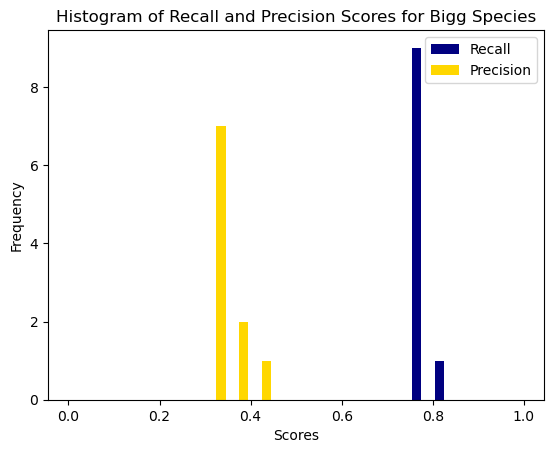

In [49]:
# Bigg species
df1 = combined_df.groupby('model')[['recall_formula', 'precision_formula']].mean()
ax = plt.gca()
ax.hist(x=[df1['recall_formula'], df1['precision_formula']], bins=20, color=['navy', 'gold'], label=['Recall', 'Precision'], range=(0, 1))
ax.set_xlabel('Scores')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Recall and Precision Scores for Bigg Species')
ax.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'biomd_spec_hist.png'), dpi=300, bbox_inches='tight', pad_inches=0.0)

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/1062924380.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy = df.groupby('name_length_bin')['accuracy'].mean().reset_index()


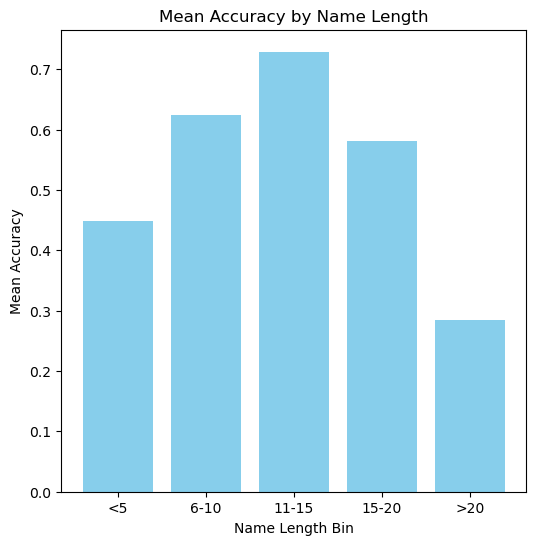

In [5]:
df = pd.read_csv(output_dir+"biomd_species_accuracy_API_query10_return10.csv")

bins = [0, 5, 10, 15, 20, float('inf')]
labels = ['<5', '6-10', '11-15', '15-20', '>20']
df['name_length_bin'] = pd.cut(df['name_length'], bins=bins, labels=labels)

mean_accuracy = df.groupby('name_length_bin')['accuracy'].mean().reset_index()
plt.figure(figsize=(6, 6))
plt.bar(mean_accuracy['name_length_bin'], mean_accuracy['accuracy'], color='skyblue')
plt.title('Mean Accuracy by Name Length')
plt.xlabel('Name Length Bin')
plt.ylabel('Mean Accuracy')
plt.show()

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/2268432972.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy = df.groupby('name_length_bin')['accuracy'].mean().reset_index()


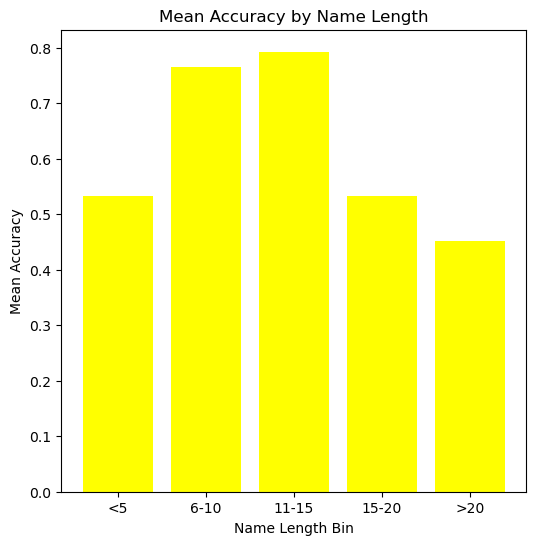

In [10]:
df = pd.read_csv(output_dir+"biomd_species_accuracy_AMAS.csv")

bins = [0, 5, 10, 15, 20, float('inf')]
labels = ['<5', '6-10', '11-15', '15-20', '>20']
df['name_length_bin'] = pd.cut(df['name_length'], bins=bins, labels=labels)

mean_accuracy = df.groupby('name_length_bin')['accuracy'].mean().reset_index()
plt.figure(figsize=(6, 6))
plt.bar(mean_accuracy['name_length_bin'], mean_accuracy['accuracy'], color='yellow')
plt.title('Mean Accuracy by Name Length')
plt.xlabel('Name Length Bin')
plt.ylabel('Mean Accuracy')
plt.show()

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/4253970423.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_api = df_api.groupby('name_length_bin')['accuracy'].mean().reset_index(name='API')
/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/4253970423.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_amas = df_amas.groupby('name_length_bin')['accuracy'].mean().reset_index(name='AMAS')


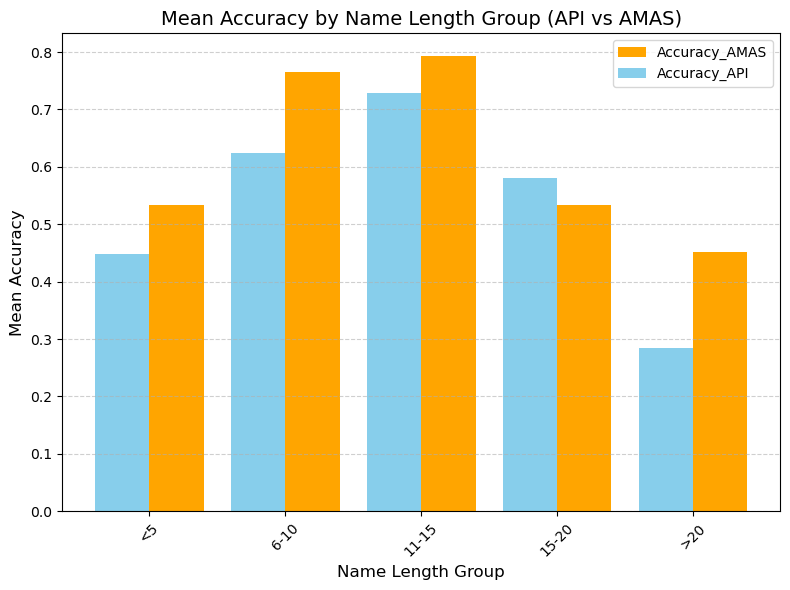

In [23]:
# Load the two DataFrames
df_api = pd.read_csv(output_dir+'biomd_species_accuracy_API_query10_return10.csv')
df_amas = pd.read_csv(output_dir+'biomd_species_accuracy_AMAS.csv')

# Define bins and labels for name_length
bins = [0, 5, 10, 15, 20, float('inf')]
labels = ['<5', '6-10', '11-15', '15-20', '>20']

# Add a column for name_length bins
df_api['name_length_bin'] = pd.cut(df_api['name_length'], bins=bins, labels=labels)
df_amas['name_length_bin'] = pd.cut(df_amas['name_length'], bins=bins, labels=labels)

# Calculate mean accuracy for each group
mean_accuracy_api = df_api.groupby('name_length_bin')['accuracy'].mean().reset_index(name='API')
mean_accuracy_amas = df_amas.groupby('name_length_bin')['accuracy'].mean().reset_index(name='AMAS')

# Merge the results
mean_accuracy = pd.merge(mean_accuracy_api, mean_accuracy_amas, on='name_length_bin')

# Plotting
x = np.arange(len(mean_accuracy))  # X-axis positions
bar_width = 0.4
plt.figure(figsize=(8, 6))
plt.bar(x + bar_width/2, mean_accuracy['AMAS'], width=bar_width, label='Accuracy_AMAS', color='orange')
plt.bar(x - bar_width/2, mean_accuracy['API'], width=bar_width, label='Accuracy_API', color='skyblue')

# Customizations
plt.xticks(x, mean_accuracy['name_length_bin'], rotation=45)
plt.xlabel('Name Length Group', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.title('Mean Accuracy by Name Length Group (API vs AMAS)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/735618041.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_api = df_api.groupby('name_length_bin')['accuracy'].mean().reset_index(name='API')
/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/735618041.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_amas = df_amas.groupby('name_length_bin')['accuracy'].mean().reset_index(name='AMAS')


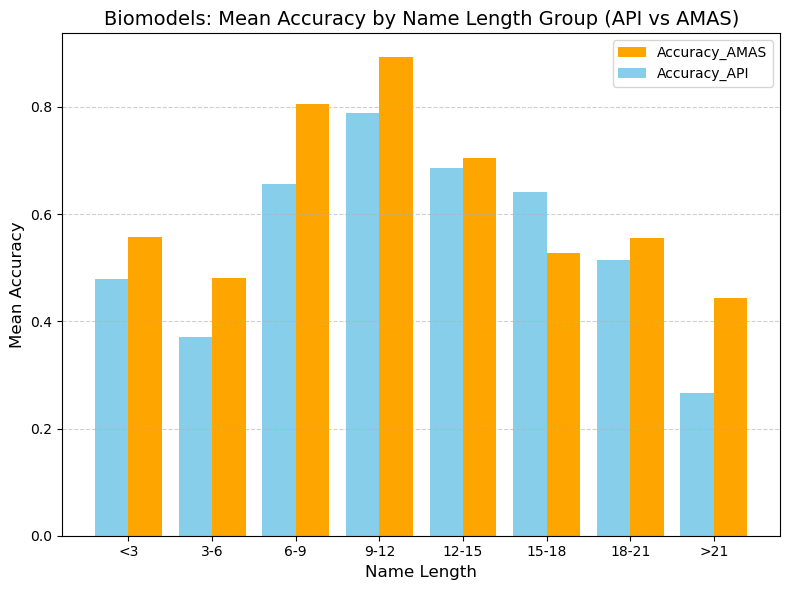

In [51]:
# Load the two DataFrames
df_api = pd.read_csv(output_dir+'biomd_species_accuracy_API_query10_return10.csv')
df_amas = pd.read_csv(output_dir+'biomd_species_accuracy_AMAS.csv')

# Define bins and labels for name_length
bins = [0, 3, 6, 9, 12, 15, 18, 21, float('inf')]
labels = ['<3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21','>21']

# Add a column for name_length bins
df_api['name_length_bin'] = pd.cut(df_api['name_length'], bins=bins, labels=labels)
df_amas['name_length_bin'] = pd.cut(df_amas['name_length'], bins=bins, labels=labels)

# Calculate mean accuracy for each group
mean_accuracy_api = df_api.groupby('name_length_bin')['accuracy'].mean().reset_index(name='API')
mean_accuracy_amas = df_amas.groupby('name_length_bin')['accuracy'].mean().reset_index(name='AMAS')

# Merge the results
mean_accuracy = pd.merge(mean_accuracy_api, mean_accuracy_amas, on='name_length_bin')

# Plotting
x = np.arange(len(mean_accuracy))  # X-axis positions
bar_width = 0.4
plt.figure(figsize=(8, 6))
plt.bar(x + bar_width/2, mean_accuracy['AMAS'], width=bar_width, label='Accuracy_AMAS', color='orange')
plt.bar(x - bar_width/2, mean_accuracy['API'], width=bar_width, label='Accuracy_API', color='skyblue')

# Customizations
plt.xticks(x, mean_accuracy['name_length_bin'])
plt.xlabel('Name Length', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.title('Biomodels: Mean Accuracy by Name Length Group (API vs AMAS)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/3067897486.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_api = df_api.groupby('name_length_bin')['accuracy'].mean().reset_index(name='API')
/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_71194/3067897486.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_amas = df_amas.groupby('name_length_bin')['accuracy'].mean().reset_index(name='AMAS')


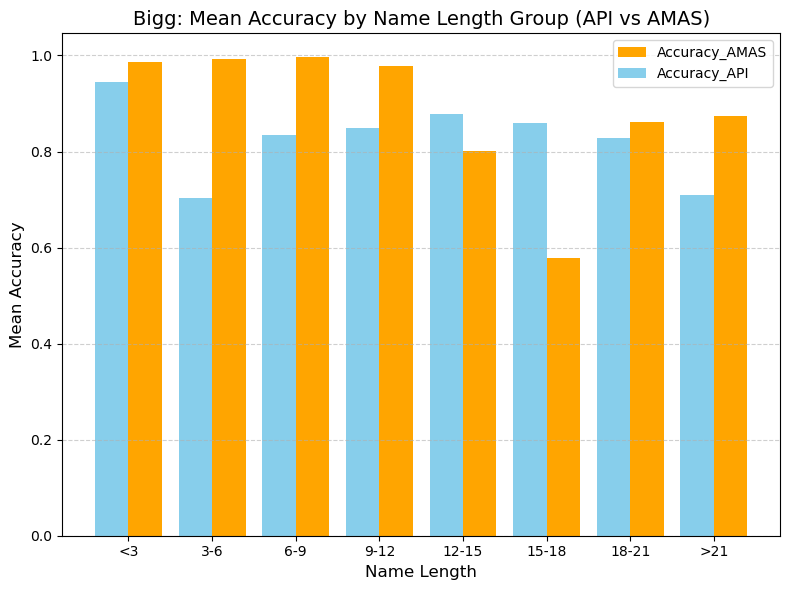

In [52]:
# Load the two DataFrames
df_api = pd.read_csv(output_dir+'bigg_species_accuracy_API_query10_return10_first10.csv')
df_amas = pd.read_csv(output_dir+'bigg_species_accuracy_AMAS.csv')

# Define bins and labels for name_length
bins = [0, 3, 6, 9, 12, 15, 18, 21, float('inf')]
labels = ['<3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21','>21']

# Add a column for name_length bins
df_api['name_length_bin'] = pd.cut(df_api['name_length'], bins=bins, labels=labels)
df_amas['name_length_bin'] = pd.cut(df_amas['name_length'], bins=bins, labels=labels)

# Calculate mean accuracy for each group
mean_accuracy_api = df_api.groupby('name_length_bin')['accuracy'].mean().reset_index(name='API')
mean_accuracy_amas = df_amas.groupby('name_length_bin')['accuracy'].mean().reset_index(name='AMAS')

# Merge the results
mean_accuracy = pd.merge(mean_accuracy_api, mean_accuracy_amas, on='name_length_bin')

# Plotting
x = np.arange(len(mean_accuracy))  # X-axis positions
bar_width = 0.4
plt.figure(figsize=(8, 6))
plt.bar(x + bar_width/2, mean_accuracy['AMAS'], width=bar_width, label='Accuracy_AMAS', color='orange')
plt.bar(x - bar_width/2, mean_accuracy['API'], width=bar_width, label='Accuracy_API', color='skyblue')

# Customizations
plt.xticks(x, mean_accuracy['name_length_bin'])
plt.xlabel('Name Length', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.title('Bigg: Mean Accuracy by Name Length Group (API vs AMAS)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()